# Backtest Lab

Visualize `Close` + `EMA_50` with executed BUY/SELL markers and portfolio equity curve.

- Data sources: `out/trend/<SYMBOL>.csv`, `out/backtests/<SYMBOL>_trades.csv`, `out/backtests/<SYMBOL>_equity_curve.csv`
- Execution model: next-day open (from `backtest_long.py`)



Trend file: out/trend/APO.csv
Trades file: out/backtests/APO_trades.csv
Equity file: out/backtests/APO_equity_curve.csv
Summary file: out/backtests/APO_summary.csv
Window: 2023-02-14 -> 2026-02-13
Buy markers in window: 7
Sell markers in window: 6


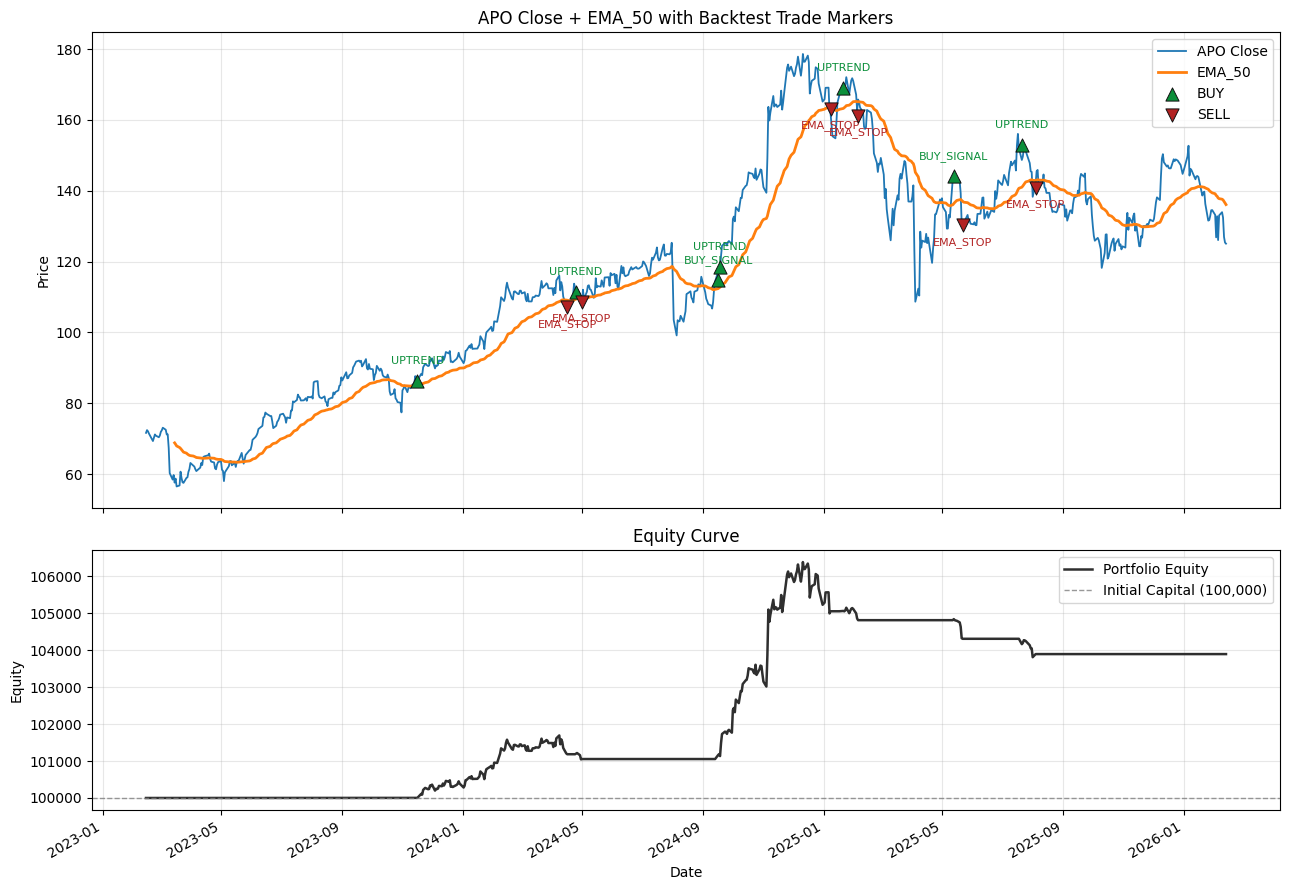

Summary Metrics
  InitialCapital: 100000.00
  EndingEquity: 103895.42
  TotalReturnPct: 3.8954
  RealizedPnL: 3895.42
  TradeExecutions: 13
  RoundTrips: 6
  WinRatePct: 33.33
  MaxDrawdownPct: 2.4206
  FinalCash: 103895.42
  FinalShares: 0
  LastDate: 2026-02-13
Recent trades:
  2024-09-18  BUY  reason=UPTREND  shares=42  price=118.540000  pnl=0.000000
  2025-01-08  SELL  reason=EMA_STOP  shares=86  price=163.130000  pnl=4000.620000
  2025-01-21  BUY  reason=UPTREND  shares=31  price=168.960000  pnl=0.000000
  2025-02-05  SELL  reason=EMA_STOP  shares=31  price=161.170000  pnl=-241.490000
  2025-05-13  BUY  reason=BUY_SIGNAL  shares=36  price=144.260000  pnl=0.000000
  2025-05-22  SELL  reason=EMA_STOP  shares=36  price=130.260000  pnl=-504.000000
  2025-07-21  BUY  reason=UPTREND  shares=34  price=152.950000  pnl=0.000000
  2025-08-04  SELL  reason=EMA_STOP  shares=34  price=140.770000  pnl=-414.120000


In [1]:
from pathlib import Path
import csv
from datetime import date, timedelta
import matplotlib.pyplot as plt

SYMBOL = "APO"
YEARS_TO_PLOT = 3  # Set to None to show full history


def resolve_data_dir(subdir: str) -> Path:
    candidates = [Path.cwd(), Path.cwd().parent]
    for candidate in candidates:
        target = candidate / "out" / subdir
        if target.exists():
            return target
    raise FileNotFoundError(
        f"Could not find out/{subdir}. Run Jupyter from repo root or notebooks/."
    )


def load_rows(csv_path: Path) -> list[dict[str, str]]:
    with csv_path.open("r", encoding="utf-8", newline="") as handle:
        reader = csv.DictReader(handle)
        rows = list(reader)
    if not rows:
        raise ValueError(f"No rows found in {csv_path}")
    return rows


def parse_float(value: str | None) -> float | None:
    raw = (value or "").strip()
    if not raw:
        return None
    return float(raw)


trend_dir = resolve_data_dir("trend")
backtest_dir = resolve_data_dir("backtests")

trend_csv = trend_dir / f"{SYMBOL}.csv"
trades_csv = backtest_dir / f"{SYMBOL}_trades.csv"
equity_csv = backtest_dir / f"{SYMBOL}_equity_curve.csv"
summary_csv = backtest_dir / f"{SYMBOL}_summary.csv"

if not trend_csv.exists():
    raise FileNotFoundError(f"Missing trend file: {trend_csv}")
if not trades_csv.exists() or not equity_csv.exists() or not summary_csv.exists():
    raise FileNotFoundError(
        "Missing backtest outputs. Run: "
        f"python3 backtest_long.py --symbol {SYMBOL} --initial-capital 100000 --allocation-pct 5 --ema-stop-column EMA_50"
    )

trend_rows = load_rows(trend_csv)
trade_rows = load_rows(trades_csv)
equity_rows = load_rows(equity_csv)
summary_rows = load_rows(summary_csv)

trend_rows.sort(key=lambda row: row["Date"])
trade_rows.sort(key=lambda row: row["Date"])
equity_rows.sort(key=lambda row: row["Date"])
summary = summary_rows[0]

trend_by_date = {row["Date"]: row for row in trend_rows}

dates: list[date] = []
close_prices: list[float] = []
ema50_values: list[float | None] = []
equity_values: list[float] = []

for eq_row in equity_rows:
    row_date = eq_row["Date"]
    trend_row = trend_by_date.get(row_date)
    if trend_row is None:
        continue

    row_close = parse_float(trend_row.get("Close"))
    row_ema50 = parse_float(trend_row.get("EMA_50"))
    row_equity = parse_float(eq_row.get("Equity"))
    if row_close is None or row_equity is None:
        continue

    dates.append(date.fromisoformat(row_date))
    close_prices.append(row_close)
    ema50_values.append(row_ema50)
    equity_values.append(row_equity)

if not dates:
    raise ValueError("No plottable rows found")

if YEARS_TO_PLOT is None:
    start_idx = 0
else:
    window_start = dates[-1] - timedelta(days=365 * YEARS_TO_PLOT)
    start_idx = next((idx for idx, d in enumerate(dates) if d >= window_start), 0)

plot_dates = dates[start_idx:]
plot_close = close_prices[start_idx:]
plot_ema50 = ema50_values[start_idx:]
plot_equity = equity_values[start_idx:]

window_start_date = plot_dates[0]
window_end_date = plot_dates[-1]
display_root = trend_dir.parent.parent

buy_events: list[dict[str, object]] = []
sell_events: list[dict[str, object]] = []
for row in trade_rows:
    event_date = date.fromisoformat(row["Date"])
    if event_date < window_start_date or event_date > window_end_date:
        continue

    price = parse_float(row.get("Price"))
    if price is None:
        continue

    event = {
        "date": event_date,
        "price": price,
        "reason": (row.get("Reason") or "").strip(),
        "shares": int((row.get("Shares") or "0").strip() or "0"),
    }

    action = (row.get("Action") or "").strip().upper()
    if action == "BUY":
        buy_events.append(event)
    elif action == "SELL":
        sell_events.append(event)

print(f"Trend file: {trend_csv.relative_to(display_root).as_posix()}")
print(f"Trades file: {trades_csv.relative_to(display_root).as_posix()}")
print(f"Equity file: {equity_csv.relative_to(display_root).as_posix()}")
print(f"Summary file: {summary_csv.relative_to(display_root).as_posix()}")
print(f"Window: {window_start_date} -> {window_end_date}")
print(f"Buy markers in window: {len(buy_events)}")
print(f"Sell markers in window: {len(sell_events)}")

fig, (ax_price, ax_equity) = plt.subplots(
    2,
    1,
    figsize=(13, 9),
    sharex=True,
    gridspec_kw={"height_ratios": [2.2, 1.2]},
)

ax_price.plot(plot_dates, plot_close, label=f"{SYMBOL} Close", color="#1f77b4", linewidth=1.3)
ax_price.plot(plot_dates, plot_ema50, label="EMA_50", color="#ff7f0e", linewidth=2.0)

if buy_events:
    ax_price.scatter(
        [event["date"] for event in buy_events],
        [event["price"] for event in buy_events],
        marker="^",
        s=90,
        color="#0b8f3a",
        edgecolors="#111111",
        linewidths=0.7,
        label="BUY",
        zorder=7,
    )

if sell_events:
    ax_price.scatter(
        [event["date"] for event in sell_events],
        [event["price"] for event in sell_events],
        marker="v",
        s=90,
        color="#b22222",
        edgecolors="#111111",
        linewidths=0.7,
        label="SELL",
        zorder=7,
    )

for event in buy_events:
    ax_price.annotate(
        event["reason"],
        (event["date"], event["price"]),
        textcoords="offset points",
        xytext=(0, 12),
        ha="center",
        fontsize=8,
        color="#0b8f3a",
    )

for event in sell_events:
    ax_price.annotate(
        event["reason"],
        (event["date"], event["price"]),
        textcoords="offset points",
        xytext=(0, -14),
        ha="center",
        fontsize=8,
        color="#b22222",
    )

ax_price.set_title(f"{SYMBOL} Close + EMA_50 with Backtest Trade Markers")
ax_price.set_ylabel("Price")
ax_price.grid(alpha=0.3)
ax_price.legend(loc="best")

initial_capital = parse_float(summary.get("InitialCapital")) or 0.0
ax_equity.plot(plot_dates, plot_equity, label="Portfolio Equity", color="#2f2f2f", linewidth=1.8)
if initial_capital > 0:
    ax_equity.axhline(
        initial_capital,
        color="#7f7f7f",
        linestyle="--",
        linewidth=1.0,
        alpha=0.8,
        label=f"Initial Capital ({initial_capital:,.0f})",
    )

ax_equity.set_title("Equity Curve")
ax_equity.set_ylabel("Equity")
ax_equity.set_xlabel("Date")
ax_equity.grid(alpha=0.3)
ax_equity.legend(loc="best")

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

print("Summary Metrics")
for key in [
    "InitialCapital",
    "EndingEquity",
    "TotalReturnPct",
    "RealizedPnL",
    "TradeExecutions",
    "RoundTrips",
    "WinRatePct",
    "MaxDrawdownPct",
    "FinalCash",
    "FinalShares",
    "LastDate",
]:
    print(f"  {key}: {summary.get(key, '')}")

print("Recent trades:")
for row in trade_rows[-8:]:
    print(
        f"  {row['Date']}  {row['Action']}  reason={row['Reason']}  "
        f"shares={row['Shares']}  price={row['Price']}  pnl={row['RealizedPnL']}"
    )

